## Library imports

In [1]:
# import all necessary libraries
import os
from datetime import datetime, timedelta
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

import random
from osgeo import gdal
from pathlib import Path
import io
from scipy.sparse import csr_matrix
from scipy.sparse import load_npz

import zipfile
from collections import defaultdict

import re
from tqdm import tqdm
import shutil
import calendar

import rasterio as rio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.shutil import copy
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import Affine
from rasterio.merge import merge

import joblib
import math
import cv2
from scipy import sparse
import traceback

import pyproj
from pyproj import Proj

from shapely.ops import transform
from shapely.geometry import Polygon

import multiprocessing
from multiprocessing.pool import ThreadPool
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

import time
import random

# GIS

In [49]:
s2_tiles = gp.read_file('/scratch/user/anshulya/hls/data/auxiliary/gis/s2-tiles.geojson')
conus = gp.read_file('/scratch/user/anshulya/hls/data/auxiliary/gis/s_05mr24/s_05mr24.shp')
s2_res = pd.read_csv('/scratch/user/anshulya/hls/data/auxiliary/gis/sentinel_tiles.csv')
grand = gp.read_file('/scratch/user/anshulya/hls/data/auxiliary/gis/hls_reservoirs.geojson')

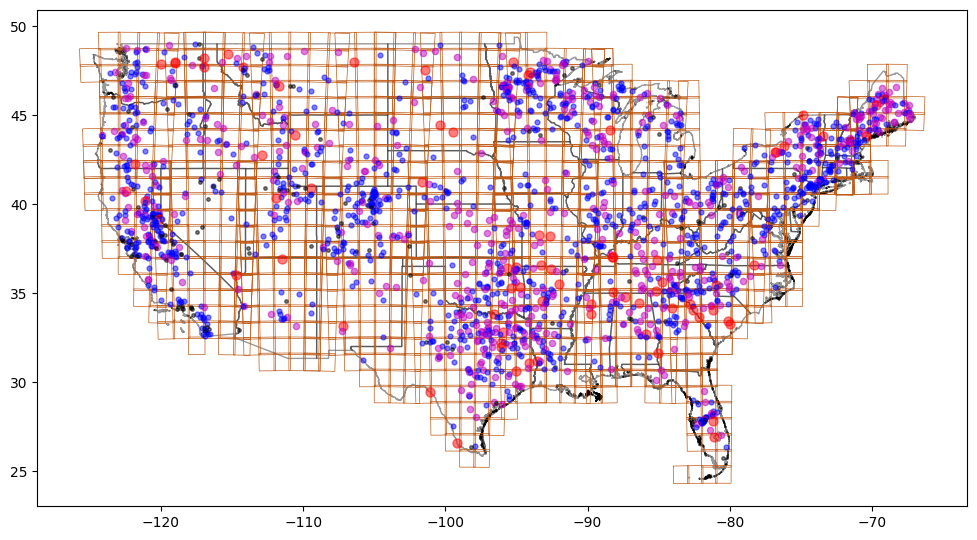

In [50]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
conus.plot(ax = ax, facecolor='none', ec = 'k',alpha=0.4)
s2_tiles.plot(ax = ax, facecolor='none', ec = '#bf5b17', linewidth=0.5)

for gid in grand['GRAND_ID']:
    x = grand.loc[grand['GRAND_ID']==gid, 'LONG_DD']
    y = grand.loc[grand['GRAND_ID']==gid, 'LAT_DD']
    s = grand.loc[grand['GRAND_ID']==gid, 'AREA_SKM'].values[0]
    if s<1:
        ax.plot(x, y, 'k.-', markersize=5, alpha=0.5)
    elif s<10:     
        ax.plot(x, y, 'b.-', markersize=7, alpha=0.5)
    elif s<100:
        ax.plot(x, y, 'm.-', markersize=9, alpha=0.5)
    else:
        ax.plot(x, y, 'r.-', markersize=13, alpha=0.5)
plt.show()

# Data Processing for a single reservoir

In [51]:
grand_id = 610 # GRanD v1.3 ID for the reservoir you are interested in

In [52]:
for idx, row in grand[grand['GRAND_ID']==grand_id].iterrows():
    print('Reservoir Name: ', row['RES_NAME'])
    print('Dam Name: ', row['DAM_NAME'])
    print('River Name: ', row['RIVER'])
    print('Reservoir Area: ', row['AREA_SKM'], ' sq. km')
    print('Reservoir Location: ', row['LAT_DD'], row['LONG_DD'])

Reservoir Name:  Lake Mead
Dam Name:  Hoover
River Name:  Colorado River
Reservoir Area:  580.95  sq. km
Reservoir Location:  36.018191 -114.735006


In [53]:
down_tiles = s2_res[s2_res['GRAND_ID']==grand_id]['Name'].values # tiles to download
print(down_tiles)

['11SPA' '11SPV' '11SQA' '11SQV' '12STE' '12STF']


### Steps to download the tiles:
1. Update the tile names in ~/code/bulk_download/tiles/tile_id.txt with each tile name separated by a space. eg: '11SPA 11SPV 11SQA 11SQV 12STE 12STF'
2. Edit the job file named 'hls_bulk.sh' on your HPC environment.
3. Populate the last line of the job file with your specific paths: bash ~/code/bulk_download/getHLS.sh ~/bulk_download/tiles/tile_id.txt <start-date> <end-date> <data-download-directory>. eg: bash ~/code/bulk_download/getHLS.sh ~/bulk_download/tiles/tile_id.txt 2016-01-01 2023-12-31 ~/data/raw_tiles/
4. Run the script rearrange_tiles_script.sh
5. Your downloaded tiles will be available in ~/data/cluster/

In [54]:
current_tiles = ['11SPA', '11SPV', '11SQA', '11SQV', '12STE', '12STF'] # update the names of the tiles here

In [55]:
res_list = [x for x in s2_res.loc[s2_res['Name'].isin(current_tiles),'GRAND_ID'].unique()]
print(res_list) # these are the reservoirs that either fully or partially lie in the current tiles

[608, 610, 616]


In [56]:
# current_todo = 610 # you can update this variable with the reservoir you are interested in
current_todo = res_list # if you are interested in all the reservoirs in your downloaded tiles

In [57]:
todo_res_list = {}
ext_res = []
print('Reservoirs only partially overlapping with the current tiles: ')
print('--------------------------------------')
for r in current_todo:
    tiles = s2_res.loc[s2_res['GRAND_ID']==r,'Name'].unique()
    rogue = [t for t in tiles if t not in current_tiles]
    
    if len(rogue)>0:
        # print(r, tiles)
        print(r, ', Other tiles required for this reservoir: ', [t for t in tiles if t not in current_tiles])
        ext_res.append(r)
    else:
        # d_tiles = [t for t in tiles if t in todo_tiles]
        todo_res_list[r] = list(tiles)
print('Reservoirs that can be processed: ',len(todo_res_list),'; Partial reservoirs: ', len(ext_res))

Reservoirs only partially overlapping with the current tiles: 
--------------------------------------
616 , Other tiles required for this reservoir:  ['11SQU']
Reservoirs that can be processed:  2 ; Partial reservoirs:  1


## Handling Partial Reservoirs
Although we only want to process reservoirs that lie entirely inside the currently downloaded tiles, we might still be interested in reservoirs which partially overlap. Hence, plotting all the partial reservoirs along with the current tiles gives us a better idea

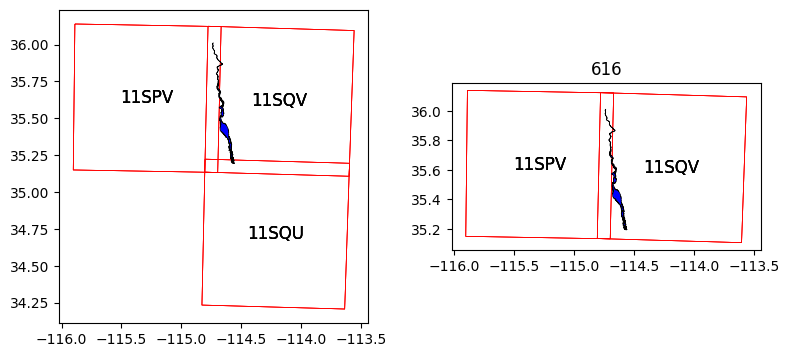

In [59]:
for r in ext_res:
    tiles = s2_res.loc[s2_res['GRAND_ID']==r,'Name'].unique()
    d_tiles = [t for t in tiles if t in current_tiles]

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    s2_tiles[s2_tiles['Name'].isin(tiles)].plot(ax = ax[0], facecolor='None', ec = 'r', linewidth=0.5)
    grand[grand['GRAND_ID'].isin([r])].plot(ax = ax[0], facecolor='blue', ec = 'k', linewidth=0.5)
    
    for _, row in s2_tiles[(s2_tiles['Name'].isin(tiles))].iterrows():
        centroid = row['geometry'].centroid
        ax[0].text(centroid.x, centroid.y, row['Name'], fontsize=12, ha='center', va='center', color='black')
    
    s2_tiles[s2_tiles['Name'].isin(d_tiles)].plot(ax = ax[1], facecolor='None', ec = 'r', linewidth=0.5)
    grand[grand['GRAND_ID'].isin([r])].plot(ax = ax[1], facecolor='blue', ec = 'k', linewidth=0.5)

    for _, row in s2_tiles[(s2_tiles['Name'].isin(d_tiles))].iterrows():
        centroid = row['geometry'].centroid
        ax[1].text(centroid.x, centroid.y, row['Name'], fontsize=12, ha='center', va='center', color='black')

    plt.title(r)
    plt.tight_layout()
    plt.show()    

* Current tiles (shown on the right) overlap the entire reservoir, hence we may go ahead with processing this reservoir as well

In [60]:
okay_rogue = [616] # Add the partially covered reservoirs here if you want to include them in your processing as well

In [62]:
todo_res_list = {}
ext_res = []
for r in current_todo:
    tiles = s2_res.loc[s2_res['GRAND_ID']==r,'Name'].unique()
    rogue = [t for t in tiles if t not in current_tiles]
    if len(rogue)>0:
        if r in okay_rogue:
            d_tiles = [t for t in tiles if t in current_tiles]
            todo_res_list[r] = list(d_tiles)
        else:
            print(r, [t for t in tiles if t not in current_tiles])
            ext_res.append(r)
    else:
        todo_res_list[r] = list(tiles)
print('Reservoirs to be processed: ',len(todo_res_list),'; Reservoirs not processed: ', len(ext_res))

Reservoirs to be processed:  3 ; Reservoirs not processed:  0


## Find out the maximum extent of the reservoirs (important for cloud correction)

In [64]:
todo_res_gid = todo_res_list.keys()
print(len(todo_res_gid))

3


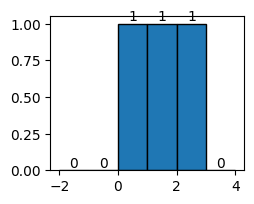

In [65]:
data = np.log10(grand.loc[grand['GRAND_ID'].isin(todo_res_gid), 'AREA_SKM'].values)

# Define bin edges: <1, 1, 10, 100, 1000 km2 (log10 values: -inf, 0, 1, 2, 3)
bins = [-2, -1, 0, 1, 2, 3, 4]

plt.figure(figsize=(2.5,2))

# Plot histogram
counts, edges, patches = plt.hist(data, bins=bins, edgecolor='black')

# Add count labels above each bar
for count, edge in zip(counts, edges[:-1]):
    plt.text(edge + (edges[1] - edges[0]) / 2, count, int(count), ha='center', va='bottom')

# Add labels and show plot
plt.show()

In [ ]:
max_date_df = pd.DataFrame(columns=['res_gid', 'l30_date', 's30_date'])
single_tile = 0
for r in tqdm(todo_res_gid):
    try:
        sflag = 0
        lflag = 0
        
        tiles = todo_res_list[r]
        if len(tiles)>1:
            dates = os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{tiles[0]}/unmerged_rasters')
            for t in tiles[1:]:
                dates_ = os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters')
                dates = [d for d in dates if d in dates_]
                if len(dates) == 0:
                    print('No full date for ', r)
                    break
            if len(dates)>0:
                # print('Full dates for ',r, ': ', dates)
                for d in dates:
                    s30 = 0
                    l30 = 0
                    for t in tiles:
                        if 'S30' in os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{d}'):
                            s30 = s30 + 1
                        if 'L30' in os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{d}'):
                            l30 = l30 + 1
                    if s30 == len(tiles):
                        x = np.sum([len(os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{d}/S30')) for t in tiles])
                        if x == 16*len(tiles):
                            sdate = d
                            sflag = 1
                    if l30 == len(tiles):
                        x = np.sum([len(os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{d}/L30')) for t in tiles])
                        if x == 12*len(tiles):
                            ldate = d
                            lflag = 1
                    if sflag ==1 and lflag == 1:
                        new_row = pd.DataFrame([{'res_gid': r, 'l30_date': ldate, 's30_date': sdate}])
                        max_date_df = pd.concat([max_date_df, new_row], ignore_index=True)
                        break
        else:
            single_tile = single_tile + 1
            dates = os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{tiles[0]}/unmerged_rasters')
            for d in dates:
                if 'S30' in os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{tiles[0]}/unmerged_rasters/{d}'):
                    x = np.sum([len(os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{d}/S30')) for t in tiles])
                    if x == 16*len(tiles):
                        sdate = d
                        sflag = 1
                if 'L30' in os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{tiles[0]}/unmerged_rasters/{d}'):
                    x = np.sum([len(os.listdir(f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{d}/L30')) for t in tiles])
                    if x == 12*len(tiles):
                        ldate = d
                        lflag = 1
                if sflag ==1 and lflag == 1:
                    new_row = pd.DataFrame([{'res_gid': r, 'l30_date': ldate, 's30_date': sdate}])
                    max_date_df = pd.concat([max_date_df, new_row], ignore_index=True)
                    break
    except:
        traceback.print_exc()
        continue

In [ ]:
def project_hls_latlon(hls, jrc, filename = 'hls_proj.tif'):
    projTIF = filename
    transform, width, height = calculate_default_transform(
        hls.crs, jrc.crs, hls.width, hls.height, *hls.bounds)
    kwargs = hls.meta.copy()
    kwargs.update({
        'crs': jrc.crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(projTIF, 'w', **kwargs) as dst:
        for i in range(1, hls.count + 1):
            reproject(
                source=rio.band(hls, i),
                destination=rio.band(dst, i),
                src_transform=hls.transform,
                src_crs=hls.crs,
                dst_transform=transform,
                dst_crs=jrc.crs,
                resampling=Resampling.nearest)
    return projTIF

def reproject_unmerged_rasters(save_path):
    print('start of reprojections')
    for filename in tqdm(os.listdir(save_path)):
        if filename == 'tile_metadata.csv':
            continue
        if os.path.isfile(os.path.join(save_path, filename)):
            jrc = rio.open('/scratch/user/anshulya/hls/data/383_LAKE_MEAD.tif')
            hls = rio.open(os.path.join(save_path, filename))
            project_hls_latlon(hls, jrc, os.path.join(save_path, filename))

## Merge downloaded rasters
def merge_max_rasters(res_gid, bands, l30_rasters_to_merge, save_path, sat):
    if not os.path.exists(os.path.join(save_path, sat)):
        os.makedirs(os.path.join(save_path, sat))
    
    for b in tqdm(bands):
        bandpaths = []
        for dirpath in l30_rasters_to_merge:
            bandpaths.append([os.path.join(dirpath, bname) for bname in os.listdir(dirpath) if b in bname][0])
        # print(bandpaths)
        rasters = [rio.open(raster_path) for raster_path in bandpaths]
    
        # Merge the rasters into a single dataset
        b1_merged, b1_merged_transform = merge(rasters)
    
        # Update the metadata of the merged dataset
        b1_merged_meta = rasters[0].meta.copy()
        b1_merged_meta.update({
            'height': b1_merged.shape[1],
            'width': b1_merged.shape[2],
            'transform': b1_merged_transform
        })
        
        if not os.path.exists(os.path.join(save_path, sat)):
            os.makedirs(os.path.join(save_path, sat))
        
        # Create a new raster file to store the stitched data
        output_path = os.path.join(save_path, sat, b +'_stitched_raster.tif')
        # print(output_path)
        with rio.open(output_path, 'w', **b1_merged_meta) as dst:
            dst.write(b1_merged)
        
        # Close all the input rasters
        for raster in rasters:
            raster.close()


def getFeatures(gdf):
  """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
  import json
  return [json.loads(gdf.to_json())['features'][0]['geometry']]

def clip_raster(src, res, fname = 'clipped_hls.tif'):
  coords = getFeatures(res)

  # Clip the raster with Polygon
  out_image, out_transform = mask(dataset=src, shapes=coords, crop=True, nodata=-9999)

  # Update the metadata with the new bounds and resolution
  out_meta = src.meta.copy()
  out_meta.update({
      'height': out_image.shape[1],
      'width': out_image.shape[2],
      'transform': out_transform
  })

  with rio.open(fname, 'w', **out_meta) as dest:
    dest.write(out_image)
  return fname

In [67]:
okay_max = []
for res_gid in todo_res_gid:
    flag1, flag2 = 0, 0
    if os.path.exists(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/L30/B05_clipped_raster.tif'):
        print(f'Max Landsat raster already available for: {res_gid}')
        
        # ras = rio.open(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/L30/B05_clipped_raster.tif')
        # fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
        # show(ras, ax = ax)
        # grand[grand['GRAND_ID'].isin([res_gid])].plot(ax = ax, facecolor='none', ec = 'k', linewidth=0.5)
        # plt.tight_layout()
        # plt.show()
        flag1 = 1
        
    if os.path.exists(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/S30/B05_clipped_raster.tif'):
        print(f'Max Sentinel raster already available for: {res_gid}')

        # ras = rio.open(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/S30/B8A_clipped_raster.tif')
        # fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
        # show(ras, ax = ax)
        # grand[grand['GRAND_ID'].isin([res_gid])].plot(ax = ax, facecolor='none', ec = 'k', linewidth=0.5)
        # plt.tight_layout()
        # plt.show()
        flag2 = 1

    if flag1 == 1 and flag2 ==1:
        okay_max.append(res_gid)

In [68]:
def process_res_gid(res_gid):
    if res_gid in okay_max:
        return
    
    s30_date = max_date_df.loc[max_date_df['res_gid'] == res_gid, 's30_date'].values[0]
    l30_date = max_date_df.loc[max_date_df['res_gid'] == res_gid, 'l30_date'].values[0]
    
    tiles = todo_res_list[res_gid]
    print(res_gid, tiles)
    
    s30_rasters_to_merge = [
        f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{s30_date}/S30' for t in tiles
    ]
    l30_rasters_to_merge = [
        f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{l30_date}/L30' for t in tiles
    ]

    print(len(s30_rasters_to_merge), len(l30_rasters_to_merge))
    
    # Define bands to be downloaded
    l30_bands = ['B01', 'B03', 'B05', 'B06', 'B04', 'Fmask', 'B07', 'B10', 'B02', 'B11', 'SAA', 'SZA']
    s30_bands = ['B10', 'B07', 'B09', 'B04', 'B03', 'B11', 'B06', 'B12', 'B02', 'B8A', 'B08', 'B01', 'Fmask', 'B05', 'SAA', 'SZA']

    save_path = f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}'
    res = grand.loc[grand['GRAND_ID'] == res_gid]
    res.geometry = res.geometry.buffer(0.01)
    
    # L30 merge
    for dirpath in l30_rasters_to_merge:
        reproject_unmerged_rasters(dirpath)
    print('Merging rasters ... ')
    merge_max_rasters(res_gid, l30_bands, l30_rasters_to_merge, save_path, 'L30')

    print('Clipping rasters ... ')
    for f in os.listdir(f'{save_path}/L30/'):
        ras = rio.open(f'{save_path}/L30/{f}')
        cr_name = f.split('_')[0] + '_clipped_raster.tif'
        clip_raster(ras, res, f'{save_path}/L30/{cr_name}')
        ras.close()
        os.remove(f'{save_path}/L30/{f}')
    print('----------------------')

    # S30 merge
    for dirpath in s30_rasters_to_merge:
        reproject_unmerged_rasters(dirpath)
    print('Merging rasters ... ')
    merge_max_rasters(res_gid, s30_bands, s30_rasters_to_merge, save_path, 'S30')

    print('Clipping rasters ... ')
    for f in os.listdir(f'{save_path}/S30/'):
        ras = rio.open(f'{save_path}/S30/{f}')
        cr_name = f.split('_')[0] + '_clipped_raster.tif'
        clip_raster(ras, res, f'{save_path}/S30/{cr_name}')
        ras.close()
        os.remove(f'{save_path}/S30/{f}')
    print('----------------------')

[]

In [ ]:
for idx, res_gid in enumerate(todo_res_list.keys()):

    print(idx)
    if res_gid in okay_max:
        continue
    
    s30_date = max_date_df.loc[max_date_df['res_gid']==res_gid,'s30_date'].values[0]
    l30_date = max_date_df.loc[max_date_df['res_gid']==res_gid,'l30_date'].values[0]
    
    tiles = todo_res_list[res_gid]
    print(res_gid, tiles)
    
    s30_rasters_to_merge = []
    l30_rasters_to_merge = []
    
    for t in tiles:
        s30_rasters_to_merge.append(f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{s30_date}/S30')
        l30_rasters_to_merge.append(f'/scratch/user/anshulya/hls/data/cluster/{t}/unmerged_rasters/{l30_date}/L30')

    print(len(s30_rasters_to_merge),len(l30_rasters_to_merge))
    
    # Define bands to be downloaded
    l30_bands = ['B01', 'B03', 'B05', 'B06', 'B04', 'Fmask', 'B07',
            'B10', 'B02', 'B11','SAA','SZA']
    s30_bands = ['B10', 'B07', 'B09', 'B04', 'B03', 'B11', 'B06',
            'B12','B02', 'B8A', 'B08', 'B01', 'Fmask','B05','SAA','SZA']

    save_path = f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}'
    res = grand.loc[grand['GRAND_ID']==res_gid]
    res.geometry = res.geometry.buffer(0.01)
    
    #L30 merge
    for dirpath in l30_rasters_to_merge:
        reproject_unmerged_rasters(dirpath)
    print('Merging rasters ... ')
    merge_max_rasters(res_gid, l30_bands, l30_rasters_to_merge, save_path, 'L30')

    print('Clipping rasters ... ')
    for f in tqdm(os.listdir(f'{save_path}/L30/')):
        ras = rio.open(f'{save_path}/L30/{f}')
        cr_name = f.split('_')[0] + '_clipped_raster.tif'
        clip_raster(ras, res, f'{save_path}/L30/{cr_name}' )
        ras.close()
        os.remove(f'{save_path}/L30/{f}')
    print('----------------------')

    #S30 merge
    for dirpath in s30_rasters_to_merge:
        reproject_unmerged_rasters(dirpath)
    print('Merging rasters ... ')
    merge_max_rasters(res_gid, s30_bands, s30_rasters_to_merge, save_path, 'S30')

    print('Clipping rasters ... ')
    for f in tqdm(os.listdir(f'{save_path}/S30/')):
        ras = rio.open(f'{save_path}/S30/{f}')
        cr_name = f.split('_')[0] + '_clipped_raster.tif'
        clip_raster(ras, res, f'{save_path}/S30/{cr_name}' )
        ras.close()
        os.remove(f'{save_path}/S30/{f}')
    print('----------------------')
    

In [ ]:
for res_gid in todo_res_gid:
    if not (os.path.exists(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/L30/B01_clipped_raster.tif') 
            and os.path.exists(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/S30/B01_clipped_raster.tif')):
        print('Max raster does not exist for reservoir: ', res_gid)

In [ ]:
for res_gid in todo_res_gid:
    if os.path.exists(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/L30/B05_clipped_raster.tif'):
        print(f'Max Landsat raster already available for: {res_gid}')
        
        ras = rio.open(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/L30/B05_clipped_raster.tif')
        fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
        show(ras, ax = ax)
        grand[grand['GRAND_ID'].isin([res_gid])].plot(ax = ax, facecolor='none', ec = 'k', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        
    if os.path.exists(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/S30/B05_clipped_raster.tif'):
        print(f'Max Sentinel raster already available for: {res_gid}')

        ras = rio.open(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/S30/B8A_clipped_raster.tif')
        fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
        show(ras, ax = ax)
        grand[grand['GRAND_ID'].isin([res_gid])].plot(ax = ax, facecolor='none', ec = 'k', linewidth=0.5)
        plt.tight_layout()
        plt.show()

# Classification

In [71]:
todo_res_list # This dictionary describes the reservoirs to be processed along with the data tiles required to process those reservoirs

{608: ['11SPA', '11SPV'],
 610: ['11SPA', '11SPV', '11SQA', '11SQV', '12STE', '12STF'],
 616: ['11SPV', '11SQV']}

Update the script '~/code/cluster_reservoir_area.py' with this dictionary on line 757

In [72]:
todo_tiles = list(set().union(*todo_res_list.values()))
print(todo_tiles) # final list of tiles which will be used

['11SPV', '12STE', '11SQV', '11SQA', '11SPA', '12STF']


Update the script '~/code/cluster_reservoir_area.py' with this list on line 740

## Processing the reservoirs
1. Make sure that you have updated the script '~/code/cluster_reservoir_area.py', with your specific dictionary and tile list.
2. Run the job file titled 'cluster_area.sh'. The last line of the job file must be populated with your specific details: python code/cluster_reservoir_area.py <start-date> <end-date> <max-cpus>
3. The classified raster for each reservoir gets stored in '~/data/hls_classified/<grand-id>'

# Contingency Check and getting .csv files for each reservoir

In [76]:
# This piece of code makes sure that nothing went wrong during the processing of the reservoirs. 
# It checks that data from each year is avialable for all the reservoirs that were being processed.
# The variable incomplete_gid contains reservoirs for which something went wrong
new_gid = [int(f) for f in os.listdir('/scratch/user/anshulya/hls/results/hls_classified')]
incomplete_gid = []
files = ['2016.zip','2017.zip','2018.zip','2019.zip','2020.zip','2021.zip','2022.zip','2023.zip']
for g in tqdm(new_gid):
    all_exist = all(Path(f'/scratch/user/anshulya/hls/results/hls_classified/{g}/{f}').exists() for f in files)
    if not all_exist:
        incomplete_gid.append(g)

100%|██████████| 1270/1270 [06:37<00:00,  3.20it/s]


In [77]:
res_list = {608: ['11SPA', '11SPV'],
 610: ['11SPA', '11SPV', '11SQA', '11SQV', '12STE', '12STF'],
 616: ['11SPV', '11SQV']}

In [78]:
res_gids = [x for x in res_list.keys() if x in incomplete_gid]
print(len(res_gids))

0


In [ ]:
def process_gid(gid):
    """
    Processes a single GID: 
        1. Groups files by year.
        2. Creates a zip file for each year.
        3. Deletes the original files/directories.

    Args:
        gid: The GID to process.
    """
    directory_path = f'/scratch/user/anshulya/hls/results/hls_classified/{gid}'

    files_by_year = defaultdict(list)

    for file_name in os.listdir(directory_path):
        if file_name.isdigit() and len(file_name) == 7:
            year = file_name[:4]
            files_by_year[year].append(file_name)

    for year, files in files_by_year.items():
        zip_filename = f'{directory_path}/{year}.zip'

        with zipfile.ZipFile(zip_filename, 'w') as zipf:
            for file_name in files:
                file_path = os.path.join(directory_path, file_name)
                if os.path.isfile(file_path):
                    zipf.write(file_path, file_name)
                elif os.path.isdir(file_path):
                    for foldername, subfolders, filenames in os.walk(file_path):
                        for filename in filenames:
                            file_to_write = os.path.join(foldername, filename)
                            arcname = os.path.relpath(file_to_write, directory_path)
                            zipf.write(file_to_write, arcname)

        print(f"Created {zip_filename} with {len(files)} items.")

        for file_name in files:
            file_path = os.path.join(directory_path, file_name)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except OSError as e:
                print(f"Error deleting {file_name}: {e}")

In [ ]:
with Pool(processes=os.cpu_count()) as pool:  # Use all available CPU cores
    list(tqdm(pool.imap(process_gid, res_gids), total=len(res_gids)))

In [ ]:
# Visualize the surface area time series data for each reservoir
for res in res_list.keys():

    columns = ['date', 'raw_area', 'enh1_area', 'enh2_area', 'cloud_cover', 'ice_cover']
    df = pd.DataFrame(columns=columns)
    
    for y in tqdm(range(2016,2024)):
        zip_file_path = f'/scratch/user/anshulya/hls/results/hls_classified/{res}/{y}.zip'

        # Open the zip file using 'zipfile.ZipFile'
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # List all files in the zip archive
            file_names = zip_ref.namelist()
            # print("Files in the zip archive:", y, len(file_names)/3)

            dates = list(dict.fromkeys([f.split('/')[0] for f in file_names])) # removing duplicate filenames

            for d in dates:
                try:
                    date_dict = {'date':d}
                    with zip_ref.open(f'{d}/terrain.npz') as file:
                        terr = np.load(io.BytesIO(file.read()))
                        data = terr['data']
                        indices = terr['indices']
                        indptr = terr['indptr']
                        shape = terr['shape']
                        sparse_matrix = csr_matrix((data, indices, indptr), shape=shape)
                        dense_matrix = sparse_matrix.toarray()
                        
                        ta = dense_matrix[(dense_matrix==1)].shape[0]*900/10**6
                        cca = dense_matrix[(dense_matrix==2)].shape[0]*900/10**6
                        ica = dense_matrix[(dense_matrix==3)].shape[0]*900/10**6
                        
                    with zip_ref.open(f'{d}/enh1.npz') as file:
                        terr = np.load(io.BytesIO(file.read()))
                        data = terr['data']
                        indices = terr['indices']
                        indptr = terr['indptr']
                        shape = terr['shape']
                        sparse_matrix = csr_matrix((data, indices, indptr), shape=shape)
                        dense_matrix = sparse_matrix.toarray()
                        
                        enh1 = dense_matrix[(dense_matrix==1)].shape[0]*900/10**6
    
                    with zip_ref.open(f'{d}/enh2.npz') as file:
                        terr = np.load(io.BytesIO(file.read()))
                        data = terr['data']
                        indices = terr['indices']
                        indptr = terr['indptr']
                        shape = terr['shape']
                        sparse_matrix = csr_matrix((data, indices, indptr), shape=shape)
                        dense_matrix = sparse_matrix.toarray()
                        
                        enh2 = dense_matrix[(dense_matrix==1)].shape[0]*900/10**6
                        
                    date_dict['raw_area'] = ta
                    date_dict['enh1_area'] = enh1
                    date_dict['enh2_area'] = enh2
                
                    if ta + cca == 0:
                        date_dict['cloud_cover'] = 0
                    else:
                        date_dict['cloud_cover'] = cca/(ta + cca)
                        
                    if ta + ica == 0:
                        date_dict['ice_cover'] = 0
                    else:
                        date_dict['ice_cover'] = ica/(ta + ica)
    
                    df = pd.concat([df, pd.DataFrame([date_dict])])
                except:
                    continue
    df['datetime'] = pd.to_datetime(df['date'], format='%Y%j')
    df_ = df[df['cloud_cover']<0.2]
    plt.figure(figsize=(10,2))
    plt.plot(df['datetime'],df['enh1_area'],'.')
    plt.plot(df['datetime'],df['enh2_area'],'.')
    plt.plot(df_['datetime'],df_['raw_area'],'r.')
    plt.title(res)
    plt.show()
    # df.to_csv(f'~/results/new/{res}.csv') # uncomment this line if you are satisfied with the time series plots to save the .csv files